In [73]:
import transformers
import torch
import torch.nn as nn
from torch.utils import data
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import ast
from others.config import *

hyperparameters = config['hyperparameters']
gpu = ('cuda:0')

In [60]:
dataset = pd.read_csv('dataset/train.csv')

In [61]:
dataset.head(6)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [62]:
dataset = dataset.iloc[:,3:]

In [63]:
dataset.head(6)

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1


In [64]:
len(dataset)

404290

<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

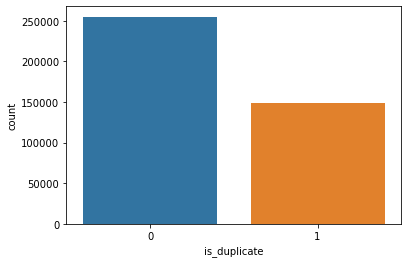

In [7]:
sns.countplot(dataset.is_duplicate)

In [8]:
data_train, data_val = train_test_split(dataset, test_size = 0.2, random_state = int(hyperparameters['RANDOM_STATE']))

In [9]:
class CustomDataset(data.Dataset):
    def __init__(self, docs_1, docs_2, labels, tokenizer, max_len=64):
        self.docs_1 = docs_1
        self.docs_2 = docs_2
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.docs_1)

    def __getitem__(self, item):
        docs_1 = str(self.docs_1[item])
        docs_2 = str(self.docs_2[item])
        labels = int(self.labels[item])
        encoded_docs_1 = tokenizer.encode_plus(
            docs_1,
            max_length = self.max_len,
            add_special_tokens = True,
            padding = "max_length",
            return_attention_mask = True,
            truncation=True,
            return_tensors = 'pt'
        )
        encoded_docs_2 = tokenizer.encode_plus(
            docs_2,
            max_length = self.max_len,
            add_special_tokens = True,
            padding = "max_length",
            return_attention_mask = True,
            truncation=True,
            return_tensors = 'pt'
        )
        return dict(
            docs_1 = docs_1, 
            docs_2 = docs_2, 
            labels = labels, 
            input_ids_1 = encoded_docs_1['input_ids'].flatten(),
            input_ids_2 = encoded_docs_2['input_ids'].flatten(),
            attention_mask_1 = encoded_docs_1['attention_mask'].flatten(), 
            attention_mask_2 = encoded_docs_2['attention_mask'].flatten()
        ) 

In [10]:
tokenizer = transformers.BertTokenizer.from_pretrained(hyperparameters['MODEL'])

In [11]:
train_encoded = CustomDataset(
    data_train.question1.to_numpy(),
    data_train.question2.to_numpy(), 
    data_train.is_duplicate.to_numpy(), 
    tokenizer, 
    int(hyperparameters['MAX_LEN'])
    )
validation_encoded = CustomDataset(
    data_val.question1.to_numpy(),
    data_val.question2.to_numpy(), 
    data_val.is_duplicate.to_numpy(), 
    tokenizer, 
    int(hyperparameters['MAX_LEN'])
    )

In [12]:
train_loader = data.DataLoader(train_encoded, batch_size = ast.literal_eval(hyperparameters['BATCH_SIZES'])[0])
validation_loader = data.DataLoader(validation_encoded, batch_size = ast.literal_eval(hyperparameters['BATCH_SIZES'])[1])

In [13]:
for data in train_loader:
    print(data['docs_1'][0])
    print(data['docs_2'][0])
    print(data['labels'][0])
    print(data['input_ids_1'][0])
    print(data['input_ids_2'][0])
    print(data['attention_mask_1'][0])
    print(data['attention_mask_2'][0])
    break

What are some of the short stories?
What are some great short stories with a twist ending?
tensor(0)
tensor([ 101, 1327, 1132, 1199, 1104, 1103, 1603, 2801,  136,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
tensor([  101,  1327,  1132,  1199,  1632,

In [14]:
for data in validation_loader:
    print(data['docs_1'][0])
    print(data['docs_2'][0])
    print(data['labels'][0])
    print(data['input_ids_1'][0])
    print(data['input_ids_2'][0])
    print(data['attention_mask_1'][0])
    print(data['attention_mask_2'][0])
    break

How do I play Pokémon GO in Korea?
How do I play Pokémon GO in China?
tensor(0)
tensor([  101,  1731,  1202,   146,  1505, 22926, 27157,  1107,  3577,   136,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0

In [84]:
class BERTModel(nn.Module):
    def __init__(self, n_output_classes):
        super(BERTModel, self).__init__()
        self.n_output_classes = n_output_classes
        self.bert = transformers.BertModel.from_pretrained(hyperparameters['MODEL'])
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(
            self.bert.config.hidden_size, 
            self.n_output_classes
            )

    def forward(self, input_ids_1, input_ids_2, attention_mask_1, attention_mask_2):
        outputs = self.bert(
            input_ids_1,
            input_ids_2,
            attention_mask_1,
            attention_mask_2
        )
        out = self.dropout(outputs[1])
        out = self.linear(out)
        return out

In [87]:
model = BERTModel(2)
model.to(gpu)

BERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  

In [88]:
for data in train_loader:
    input_ids_1 = data['input_ids_1'].to(gpu)
    input_ids_2 = data['input_ids_2'].to(gpu)
    attention_mask_1 = data['attention_mask_1'].to(gpu)
    attention_mask_2 = data['attention_mask_2'].to(gpu)
    out = model(input_ids_1, input_ids_2, attention_mask_1, attention_mask_2)
    break

RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 4.00 GiB total capacity; 2.99 GiB already allocated; 1.76 MiB free; 3.04 GiB reserved in total by PyTorch)

In [ ]:
for idx, (docs, labels, input_ids, attention_mask) in train_tqdm_bar:
        out = model(input_ids.to(gpu), attention_mask.to(gpu))
        loss = criterion(out, labels.to(gpu))

In [27]:
class PLCustomDataset(pl.LightningDataModule):
    def __init__(self, train, val, tokenizer, train_batch_size, val_batch_size, max_len):
        self.train = train,
        self.val = val,
        self.tokenizer = tokenizer,
        self.train_batch_size = train_batch_size,
        self.val_batch_size = val_batch_size,
        self.max_len = max_len
    
    def setup(self):
        self.train_dataset = CustomDataset(
            self.train,
            self.tokenizer,
            self.max_len
        )
    
        self.test_dataset = CustomDataset(
            self.val,
            self.tokenizer,
            self.max_len
        )
    
    def train_loader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.train_batch_size,
            shuffle = True,
            num_workers = 4
        )
    
    def validation_loader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = self.val_batch_size,
            num_workers = 4
        )


In [28]:
test = PLCustomDataset(
    data_train, 
    data_val, 
    tokenizer, 
    ast.literal_eval(hyperparameters['BATCH_SIZES'])[0], 
    ast.literal_eval(hyperparameters['BATCH_SIZES'])[1],
    int(hyperparameters['MAX_LEN']))

In [29]:
test.setup()

TypeError: __init__() missing 1 required positional argument: 'tokenizer'